# 2.5 Data analysis example

*Estimated time for this notebook: 20 minutes*

We're now going to bring together everything we've learned about Python so far to perform a simple but complete analysis.
We will retrieve data, do some computations based on it, and visualise the results.

As we show the code for different parts of the work, we will be touching on various aspects you may want to keep in mind, either related to Python specifically, or to research programming more generally.

## 2.5.1 Geolocation

In [1]:
import geopy  # A python library for investigating geographic information. https://pypi.org/project/geopy/

If you try to follow along on this example in an Jupyter notebook, you might find that you just got an error message.

You'll need to wait until we've covered installation of additional python libraries later in the course, then come back to this and try again.
For now, just follow along and try get the feel for how programming for data-focused research works.

In [2]:
geocoder = geopy.geocoders.Nominatim(user_agent="rse-course")
geocoder.geocode("Cambridge", exactly_one=False)

[Location(Cambridge, Cambridgeshire, Cambridgeshire and Peterborough, England, United Kingdom, (52.197584649999996, 0.13915373736874398, 0.0)),
 Location(Cambridgeshire, Cambridgeshire and Peterborough, England, United Kingdom, (52.2055314, 0.1186637, 0.0)),
 Location(Cambridge, Middlesex County, Massachusetts, United States, (42.3750997, -71.1056157, 0.0)),
 Location(Cambridge, Region of Waterloo, Southwestern Ontario, Ontario, Canada, (43.3600536, -80.3123023, 0.0)),
 Location(Cambridge, Henry County, Illinois, United States, (41.3025257, -90.1962861, 0.0)),
 Location(Cambridge, Isanti County, Minnesota, 55008, United States, (45.5727408, -93.2243921, 0.0)),
 Location(Cambridge, Story County, Iowa, 50046, United States, (41.8990768, -93.5294029, 0.0)),
 Location(Cambridge, Dorchester County, Maryland, 21613, United States, (38.5714624, -76.0763177, 0.0)),
 Location(Cambridge, Guernsey County, Ohio, 43725, United States, (40.031183, -81.5884561, 0.0)),
 Location(Cambridge, Jefferson C

Note that the results are a list of `Location` objects, where each `Location` knows its `name`, `latitude` and `longitude`.

Let's define and test a `geolocate` function, storing the result in a variable

In [3]:
def geolocate(place):
    return geocoder.geocode(place, exactly_one=False)[0][1]

In [4]:
london_location = geolocate("London")
print(london_location)

(51.5073219, -0.1276474)


## 2.5.2 Using the Yandex API

The Yandex API allows us to fetch a map of a place, given a longitude and latitude.
The URLs look like: https://static-maps.yandex.ru/1.x/?size=400,400&ll=-0.1275,51.51&z=10&l=sat&lang=en_US 
We'll probably end up working out these URLs quite a bit. So we'll make ourselves another function to build up a URL given our parameters.

In [5]:
import requests


def request_map_at(lat, long, satellite=True, zoom=12, size=(400, 400)):
    base = "https://static-maps.yandex.ru/1.x/?"
    params = dict(
        z=zoom,
        size=str(size[0]) + "," + str(size[1]),
        ll=str(long) + "," + str(lat),
        l="sat" if satellite else "map",
        lang="en_US",
    )
    return requests.get(base, params=params, timeout=60)

In [6]:
map_response = request_map_at(51.5072, -0.1275)

## 2.5.3 Checking our work

Let's see what URL we ended up with:

In [7]:
url = map_response.url
print(url)

https://static-maps.yandex.ru/1.x/?z=12&size=400%2C400&ll=-0.1275%2C51.5072&l=sat&lang=en_US


We can write **automated tests** so that if we change our code later, we can check the results are still valid.

In [8]:
assert "https://static-maps.yandex.ru/1.x/?" in url
assert "ll=-0.1275%2C51.5072" in url
assert "z=12" in url
assert "size=400%2C400" in url

Our previous function comes back with an `object` representing the web request.
In object oriented programming, we use the `.` operator to get access to a particular **property** of the object, in this case, the actual image at that URL is in the `content` property.
It's a big file, so we'll just show the first few characters here:

In [9]:
map_response.content[0:20]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00'

## 2.5.4 Displaying the results

We'll need to do this a lot, so let's wrap up our previous function in another function, to save on typing.

In [10]:
def map_at(*args, **kwargs):
    return request_map_at(*args, **kwargs).content

We can use a library that comes with Jupyter notebook to display the image.
Being able to work with variables which contain images, or documents, or any other weird kind of data, just as easily as we can with numbers or letters, is one of the really powerful things about modern programming languages like Python. 

In [11]:
from IPython.display import Image

map_png = map_at(*london_location)

In [12]:
print("The type of our map result is actually a: ", type(map_png))

The type of our map result is actually a:  <class 'bytes'>


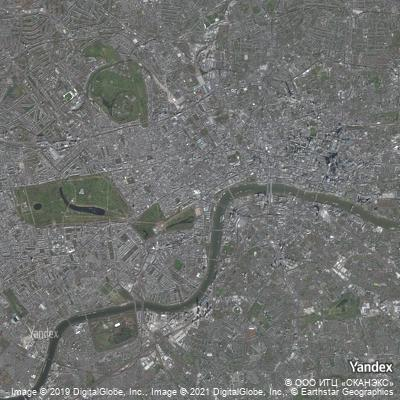

In [13]:
Image(map_png)

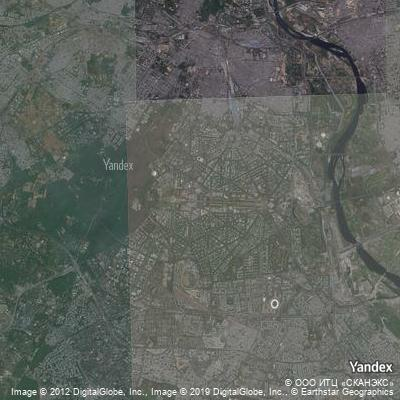

In [14]:
Image(map_at(*geolocate("New Delhi")))

## 2.5.5 Measuring urbanisation

Now we get to our research project: we want to find out how urbanised the world is.
For this we'll use satellite imagery, along a line between two cities.
We expect the satellite image to be greener in the countryside.

Let's start by importing the libraries we need.

In [15]:
from io import BytesIO  # A library to convert between files and strings

import imageio  # A library to deal with images, https://pypi.org/project/imageio/
import numpy as np  # A library to deal with matrices

and then define what we count as green:

In [16]:
def is_green(pixels):
    threshold = 1.1
    greener_than_red = pixels[:, :, 1] > threshold * pixels[:, :, 0]
    greener_than_blue = pixels[:, :, 1] > threshold * pixels[:, :, 2]
    green = np.logical_and(greener_than_red, greener_than_blue)
    return green

This code has assumed we have our pixel data for the image as a $400 \times 400 \times 3$ 3-d matrix,
with each of the three layers being red, green, and blue pixels.

We find out which pixels are green by comparing, element-by-element, the middle (green, number 1) layer to the top (red, zero) and bottom (blue, 2)

Now we just need to read in our data, which is a PNG image, and convert it into our matrix format:

In [17]:
def count_green_in_png(data):
    f = BytesIO(data)
    pixels = imageio.v2.imread(f)  # Get our PNG image as a numpy array
    return np.sum(is_green(pixels))

In [18]:
print(count_green_in_png(map_at(*london_location)))

3258


We'll also need a function to get an evenly spaced set of places between two endpoints:

In [19]:
def location_sequence(start, end, steps):
    lats = np.linspace(start[0], end[0], steps)  # "Linearly spaced" data
    longs = np.linspace(start[1], end[1], steps)
    return np.vstack([lats, longs]).transpose()

In [20]:
location_sequence(geolocate("London"), geolocate("Cambridge"), 5)

array([[ 5.15073219e+01, -1.27647400e-01],
       [ 5.16798876e+01, -6.09471157e-02],
       [ 5.18524533e+01,  5.75316868e-03],
       [ 5.20250190e+01,  7.24534530e-02],
       [ 5.21975846e+01,  1.39153737e-01]])

## 2.5.6 Visualising green content

We should display the green content to check our work:

In [21]:
def show_green_in_png(data):
    pixels = imageio.imread(BytesIO(data))  # Get our PNG image as rows of pixels
    green = is_green(pixels)

    out = green[:, :, np.newaxis] * np.array([0, 1, 0])[np.newaxis, np.newaxis, :]

    buffer = BytesIO()
    imageio.imwrite(buffer, out, format="png")
    return buffer.getvalue()

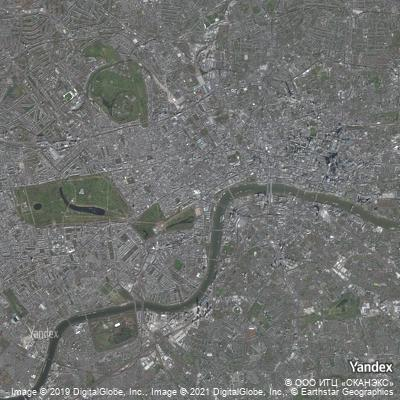

In [22]:
Image(map_at(*london_location, satellite=True))

/var/folders/_h/qlg2vf_n5ng3gwwrhnkw1k480000gr/T/ipykernel_41807/3486682063.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixels = imageio.imread(BytesIO(data))  # Get our PNG image as rows of pixels
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


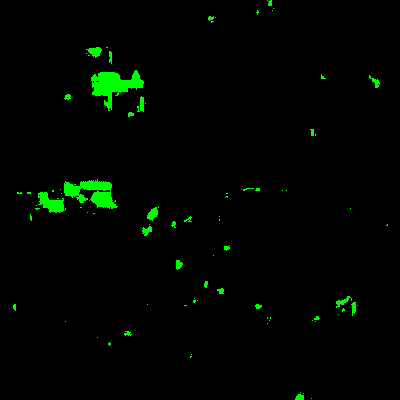

In [23]:
Image(show_green_in_png(map_at(*london_location, satellite=True)))

## 2.5.7 Looping

We can loop over each element in out list of coordinates, and get a map for that place:

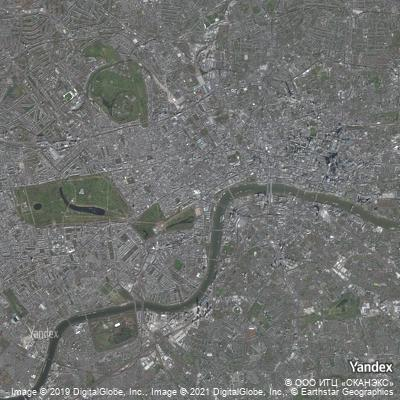

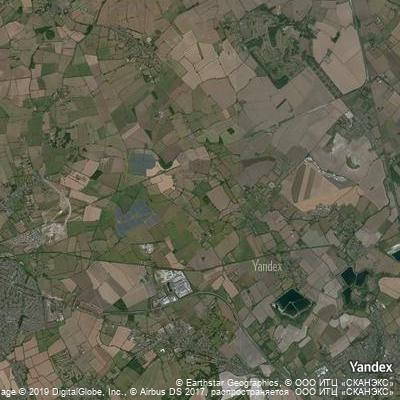

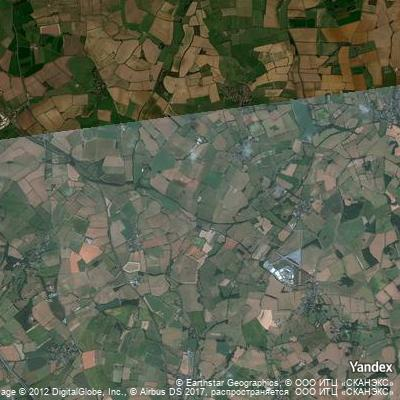

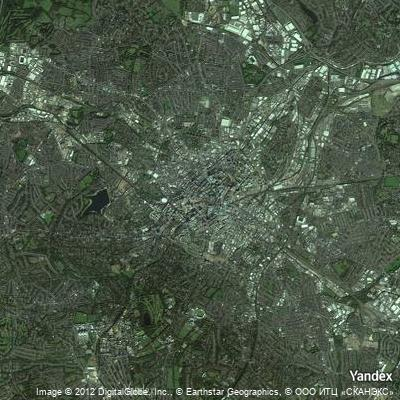

In [24]:
for location in location_sequence(geolocate("London"), geolocate("Birmingham"), 4):
    display(Image(map_at(*location)))

So now we can count the green from London to Birmingham!

In [25]:
[
    count_green_in_png(map_at(*location))
    for location in location_sequence(geolocate("London"), geolocate("Birmingham"), 10)
]

[3258, 37141, 59293, 22398, 30123, 56351, 60224, 53067, 137132, 143993]

## 2.5.8 Plotting graphs

Let's plot a graph.

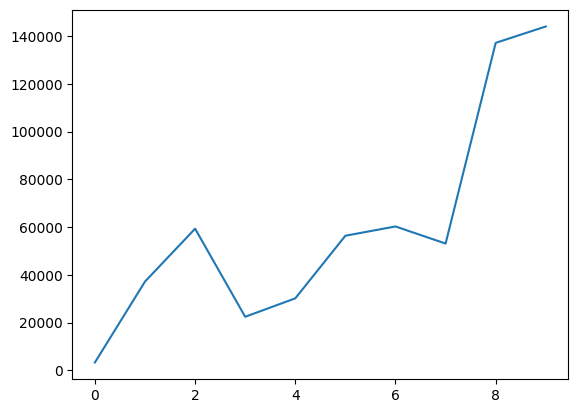

In [26]:
import matplotlib.pyplot as plt

plt.plot(
    [
        count_green_in_png(map_at(*location))
        for location in location_sequence(
            geolocate("London"), geolocate("Birmingham"), 10
        )
    ]
)

From a research perspective, of course, this code needs a lot of work. But I hope the power of using programming is clear.


## 2.5.9 Composing Program Elements

We built little pieces of useful code, to:

- Find latitude and longitude of a place
- Get a map at a given latitude and longitude
- Decide whether a (red,green,blue) triple is mainly green
- Decide whether each pixel is mainly green
- Plot a new image showing the green places
- Find evenly spaced points between two places

By putting these together, we can make a function which can plot this graph automatically for any two places:

In [27]:
def green_between(start, end, steps):
    return [
        count_green_in_png(map_at(*location))
        for location in location_sequence(geolocate(start), geolocate(end), steps)
    ]

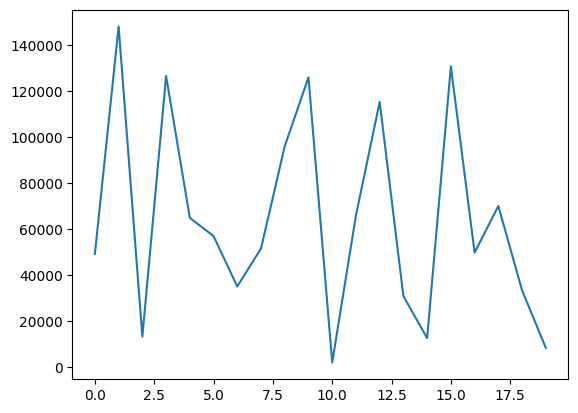

In [28]:
plt.plot(green_between("New York", "Chicago", 20))

And that's it! We've used Python to analyse data from an internet API and visualise it in interesting ways.